# Анализ оттока клиентов банка

<b>Цель проекта</b>: Проанализировать отток клиентов банка «Метанпром» и выявить клиентские сегменты, склонные к уходу, с применением методов кластеризации. Результаты анализа могут быть использованы для разработки стратегий удержания клиентов.

<b>Задачи проекта</b>:
1. Загрузка и изучение данных:
    - Загрузить данные, положить их в датафрейм.
    - Изучить общую информацию, описать. 

2. Предобработка данных:
    - Работа со столбцами (при необходимости).
    - Анализ наличия и природы пропущенных значений.
    - Обработка пропусков (удаление, заполнение или иные стратегии).
    - Кодирование категориальных признаков для дальнейшего анализа.
    - Поиск и устранение дублей (если имеются).
    - Оценка распределения значений в столбцах, выявление выбросов.

3. EDA (исследовательский анализ данных):
    - Анализ распределения признаков в разрезе оттока.
    - Выявление взаимосвязей между churn и другими признаками (корреляционный анализ).
    - Построение портретов клиентов, склонных к оттоку.

4. Статистический анализ:
    - Проверка статистических гипотез о различиях между ушедшими и оставшимися клиентами.
    - Обоснование выбора статистических тестов.
    - Анализ значимости факторов.

5. Подведение промежуточных итогов.

6. Кластеризация клиентов:
    - Формулировка задачи машинного обучения: Задача кластеризации - выделение сегментов (кластеров) клиентов на основе схожих характеристик.
    - Выбор метода кластеризации: K-Means (если данные чётко разделяются, возможна корректировка метода после EDA).
    - Выбор метрики для кластеризации: евклидово расстояние (для K-Means).
    - Оценка оптимального числа кластеров (метод Elbow).
    - Подготовка данных: масштабирование признаков, отбор релевантных характеристик.
    - Анализ полученных кластеров: интерпретация характеристик клиентов в каждом сегменте.

7. Приоритизация сегментов:
    - Определение сегментов с наибольшей склонностью к оттоку.
    - Выделение ключевых характеристик рисковых клиентов.

8. Формирование рекомендаций:
    - Разработка стратегии взаимодействия с каждым выделенным сегментом.
    - Определение потенциальных мер по снижению оттока.
    - Выявление возможностей персонализированных предложений клиентам.

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в
Ярославле и областных городах: Ростов Великий и Рыбинск.

Описание столбцов:
- `USERID` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `city` — город,
- `gender` — пол,
- `age` — возраст,
- `equity` — количество баллов собственности
- `balance` — баланс на счёте,
- `products` — количество продуктов, которыми пользуется клиент,
- `credit_card` — есть ли кредитная карта,
- `last_activity` — активный клиент,
- `EST_SALARY` — оценочный доход клиента,
- `сhurn` — признак оттока.

## Загрузка и изучение данных

Загрузим датасет, сохраним его в датафрейм и изучим общую информацию о данных.

In [1]:
# Подключение всех необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Задаем стиль графиков
sns.set(style="whitegrid")

# Методы для стат. тестов
import scipy.stats as stats
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

# Методы для кластеризации
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Настройка pandas для отображения полного текста
pd.set_option('display.max_colwidth', None)

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/bank_scrooge.csv')
data.sample(5)

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
634,141301,952.0,Ярославль,М,35.0,5,6673219.33,4,1,0,406287.12,1
7810,215319,950.0,Ярославль,М,42.0,3,1440397.46,1,1,0,311130.64,0
3702,200644,752.0,Ярославль,М,32.0,2,102215.71,1,1,0,62498.47,0
841,197887,721.0,Ярославль,М,42.0,0,NaN,1,1,1,180702.97,0
4742,208660,776.0,Ростов,Ж,53.0,3,484506.27,3,1,0,106797.50,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


В предоставленном датасете содержится информация о 10 000 клиентах банка «Метанпром», включая демографические и финансовые характеристики, а также признак оттока (`churn`). Данные представлены в 12 столбцах, среди которых числовые, категориальные и бинарные признаки. Числовые характеристики включают баллы кредитного скоринга (`score`), возраст (`age`), количество баллов собственности (`equity`), баланс на счете (`balance`), количество используемых банковских продуктов (`products`), оценочный доход (`EST_SALARY`). Категориальные признаки – это город проживания (`city`) и пол (`gender`). Бинарные признаки включают наличие кредитной карты (`credit_card`), активность клиента (`last_activity`) и сам признак оттока (`churn`). В данных присутствуют пропуски: 26 значений отсутствуют в столбце возраста (`age`), а в столбце баланса (`balance`) пропущено 2 295 значений, что составляет значительную долю данных. Остальные столбцы не содержат пропусков. 

Проверим корректность значений (уникальные значения) по столбцам.

In [4]:
# Вывод уникальных значений в столбцах
columns = ['city', 'gender', 'score', 'age', 'equity', 'products', 'credit_card', 'last_activity', 'churn']
for col in columns:
    print(f"Unique values in {col}:", data[col].unique())

Unique values in city: ['Рыбинск' 'Ярославль' 'Ростов']
Unique values in gender: ['Ж' 'М']
Unique values in score: [ 850.  861.  892.  866.  730.  856.  807.  825.  923.  906.  927.  921.
  845.  837.  815.  731.  829.  793.  876.  922.  772.  896.  871.  732.
  898.  806.  766.  776.  868.  946.  828.  786.  944.  863.  822.  794.
  924.  811.  814.  956.  935.  826.  849.  901.  893.  792.  888.  831.
  748.  820.  860.  914.  930.  948.  789.  737.  812.  933.  809.  749.
  873.  859.  950.  937.  835.  768.  767.  785.  846.  750.  816.  894.
  891.  788.  758.  787.  821.  855.  779.  791.  838.  971.  797.  841.
  915.  985.  870.  897.  763.  774.  686. 1000.  875.  819.  869.  854.
  810.  761.  802.  958.  917.  745.  736.  908.  928.  884.  853.  780.
  726.  881.  975.  852.  965.  899.  890.  836.  818.  880.  795.  916.
  775.  902.  918.  842.  771.  895.  801.  721.  966.  804.  885.  986.
  753.  832.  979.  798.  754.  756.  823.  658.  734.  954.  827.  929.
  760.  6

В столбце `products` не должно быть значения `0`. Посмотрим, сколько в датафрейме таких строк.

In [5]:
# Поиск строк, где products == 0
data.query('products == 0')

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
8957,147837,962.0,Рыбинск,Ж,79.0,3,NaN,0,0,0,25063.96,1


Скорее всего, это ошибка ведения данных. Чтобы оставить эту строку, заменим значение на `1`.

In [6]:
# Замена значения
data.loc[data['products'] == 0, 'products'] = 1

# Проверка
data.query('products == 0')

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn


Теперь все значения выглядят корректно.

Как уже сказали выше, столбцы `city` и `gender` можно считать категориальными, поэтому позже можем их закодировать для удобства. <br>
А столбцы `score` и `age` можем привести к целочисленному виду.

Таким образом, мы загрузили и изучили исходные данные.

## Предобработка данных

### Работа со столбцами

Для начала приведем названия столбцов к змеиному формату.

In [7]:
# Преобразование
data.rename(columns={'USERID': 'user_id', 'EST_SALARY': 'est_salary'}, inplace=True)

# Проверка
data.sample()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
8748,174193,788.0,Ярославль,Ж,32.0,3,251092.49,3,1,0,89966.17,0


Преобразуем данные в нужные типы. Опишем, в каких столбцах заменили тип данных и почему.

- Столбцы `score` и `age` перевести в `int` (предварительно заполнив пропуски в `age`). Поскольку пропусков в этом столбце меньше 1%, заполним их медианой, это не нарушит распределение. Но предварительно посмотрим корреляцию с другими признаками. Если корреляция заметная, заполним пропуски по сегментам, если нет - оставим медиану.
- Город (`city`) – используем One-Hot Encoding, так как городов немного, и они не имеют явного порядка.
- Пол (`gender`) – заменим `Ж` на `0`, `М` на `1`, так как это бинарная категория.

Остальные столбцы уже имеют корректные типы.

In [8]:
# Преобразование столбца score в целочисленный формат
data['score'] = data['score'].astype(int)

# Кодирование пола с помощью get_dummies
data = pd.get_dummies(data, columns=['gender'], dtype=int)

# Переименование колонок для удобства
data.rename(columns={'gender_Ж': 'is_female', 'gender_М': 'is_male'}, inplace=True)

# Проверка корректности кодировки
print(data[['is_female', 'is_male']].sum())

is_female    4995
is_male      5005
dtype: int64


In [9]:
# One-Hot Encoding для города
data = pd.get_dummies(data, columns=['city'], dtype=int)

# Проверим результат
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         10000 non-null  int64  
 1   score           10000 non-null  int64  
 2   age             9974 non-null   float64
 3   equity          10000 non-null  int64  
 4   balance         7705 non-null   float64
 5   products        10000 non-null  int64  
 6   credit_card     10000 non-null  int64  
 7   last_activity   10000 non-null  int64  
 8   est_salary      10000 non-null  float64
 9   churn           10000 non-null  int64  
 10  is_female       10000 non-null  int64  
 11  is_male         10000 non-null  int64  
 12  city_Ростов     10000 non-null  int64  
 13  city_Рыбинск    10000 non-null  int64  
 14  city_Ярославль  10000 non-null  int64  
dtypes: float64(3), int64(12)
memory usage: 1.1 MB


,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,is_female,is_male,city_Ростов,city_Рыбинск,city_Ярославль
0,183012,850,25.0,1,59214.82,2,0,1,75719.14,1,1,0,0,1,0
1,146556,861,37.0,5,850594.33,3,1,0,86621.77,0,1,0,0,1,0
2,120722,892,30.0,0,NaN,1,1,1,107683.34,0,1,0,0,1,0
3,225363,866,51.0,5,1524746.26,2,0,1,174423.53,1,1,0,0,0,1
4,157978,730,34.0,5,174.00,1,1,0,67353.16,1,0,1,0,0,1


In [10]:
# Исключаем user_id из данных перед расчетом корреляции
data_corr = data.drop(columns=['user_id'])

# Создаем индикатор пропусков
data_corr['age_missing'] = data_corr['age'].isna().astype(int)

# Вычисляем корреляцию наличия пропусков с другими признаками
correlation_with_missing = data_corr.corr()['age_missing'].drop('age_missing')

# Выводим корреляции
print("Корреляция наличия пропусков в возрасте с другими признаками:")
correlation_with_missing.sort_values(ascending=False)

Корреляция наличия пропусков в возрасте с другими признаками:


last_activity     0.025120
city_Рыбинск      0.022098
est_salary        0.011252
credit_card       0.009726
balance           0.007686
score             0.005035
is_male           0.003876
is_female        -0.003876
city_Ярославль   -0.009214
city_Ростов      -0.015114
churn            -0.018994
equity           -0.032040
products         -0.033764
age                    NaN
Name: age_missing, dtype: float64

Корреляция пропусков в `age` со всеми признаками близка к нулю, что говорит о случайном характере пропусков. Это означает, что заполнять их на основе сегментов (например, по активности или количеству продуктов) не имеет смысла, так как нет явной зависимости. Заполним эти пропуски медианой. Согласно классификации пропусков, такие данные относятся к `MCAR` (отсутствуют совершенно случайно), поэтому их заполнение медианным значением не приведет к искажению структуры данных.

In [11]:
# Заполнение пропусков в возрасте медианным значением
data['age'].fillna(data['age'].median(), inplace=True)
# Преобразование в int 
data['age'] = data['age'].astype(int)

# Проверка результата
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         10000 non-null  int64  
 1   score           10000 non-null  int64  
 2   age             10000 non-null  int64  
 3   equity          10000 non-null  int64  
 4   balance         7705 non-null   float64
 5   products        10000 non-null  int64  
 6   credit_card     10000 non-null  int64  
 7   last_activity   10000 non-null  int64  
 8   est_salary      10000 non-null  float64
 9   churn           10000 non-null  int64  
 10  is_female       10000 non-null  int64  
 11  is_male         10000 non-null  int64  
 12  city_Ростов     10000 non-null  int64  
 13  city_Рыбинск    10000 non-null  int64  
 14  city_Ярославль  10000 non-null  int64  
dtypes: float64(2), int64(13)
memory usage: 1.1 MB


Работу со столбцами выполнили.

### Работа с пропусками

Посмотрим, в каких столбцах остались пропуски и решим, как их обработаем.

In [12]:
# Подсчёт пропусков
missing_values = data.isnull().sum()
missing_percent = (missing_values / len(data)) * 100

# Оставляем только столбцы с пропусками
missing_data = missing_values[missing_values > 0].to_frame(name='Пропуски')
missing_data['Процент'] = missing_percent[missing_percent > 0]

# Вывод
missing_data

,Пропуски,Процент
balance,2295,22.95


Пропуски в `balance` (22.95%) - довольно значительная доля данных, поэтому их удаление может привести к потере полезной информации. Нужно понять их природу. Проверим, с какими характеристиками клиентов чаще всего связаны эти пропуски.

Попробуем:
- Посмотреть корреляцию с другими признаками.
- Посмотреть распределение `balance`, включая пропущенные значения.
- Проверить, зависят ли пропуски от других признаков (например, активности клиента или количества продуктов).
- Вывести статистику по `balance` для клиентов с пропущенными значениями.

In [13]:
# Исключаем user_id из данных перед расчетом корреляции
data_corr = data.drop(columns=['user_id'])

# Создаем индикатор пропусков
data_corr['balance_missing'] = data_corr['balance'].isna().astype(int)

# Вычисляем корреляцию с другими признаками
correlation_with_missing = data_corr.corr()['balance_missing'].drop('balance_missing')

# Выводим корреляции
print("Корреляция наличия пропусков в balance с другими признаками:")
correlation_with_missing.sort_values(ascending=False)

Корреляция наличия пропусков в balance с другими признаками:


est_salary        0.307154
credit_card       0.158334
score             0.138871
is_male           0.063424
city_Ярославль    0.055919
last_activity     0.028362
city_Рыбинск     -0.013668
age              -0.029112
city_Ростов      -0.061508
is_female        -0.063424
churn            -0.249421
products         -0.487387
equity           -0.709951
balance                NaN
Name: balance_missing, dtype: float64

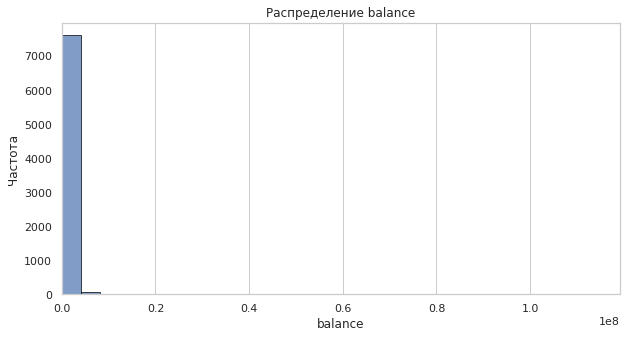

Зависимость пропусков от churn, активности и количества продуктов:
   churn  last_activity  products  count
0      0              0         1    861
1      0              0         2    145
2      0              0         3     18
3      0              1         1   1081
4      0              1         2    169
5      0              1         3      8
6      1              0         1      7
7      1              0         3      3
8      1              1         1      2
9      1              1         2      1

Статистика клиентов с пропущенным balance:


,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,is_female,is_male,city_Ростов,city_Рыбинск,city_Ярославль
count,2295.000000,2295.000000,2295.000000,2295.000000,0.0,2295.000000,2295.000000,2295.000000,2.295000e+03,2295.000000,2295.000000,2295.000000,2295.000000,2295.000000,2295.000000
mean,172069.447930,865.352070,42.078431,0.050980,NaN,1.162527,0.815686,0.549455,2.263102e+05,0.005664,0.441394,0.558606,0.102397,0.258388,0.639216
std,33337.084589,89.603091,11.901109,0.225872,NaN,0.401814,0.387824,0.497657,1.997718e+05,0.075066,0.496662,0.496662,0.303235,0.437844,0.480333
min,114182.000000,642.000000,18.000000,0.000000,NaN,1.000000,0.000000,0.000000,2.027403e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,143095.500000,871.000000,33.000000,0.000000,NaN,1.000000,1.000000,0.000000,1.203477e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,172659.000000,903.000000,40.000000,0.000000,NaN,1.000000,1.000000,1.000000,1.741607e+05,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,201551.000000,922.000000,49.000000,0.000000,NaN,1.000000,1.000000,1.000000,2.400150e+05,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,229145.000000,990.000000,86.000000,3.000000,NaN,3.000000,1.000000,1.000000,1.333687e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
# Гистограмма для balance (включая NaN)
# Определяем разумный диапазон для оси X
balance_min = data['balance'].min()
balance_max = data['balance'].max()
balance_range = np.linspace(balance_min, balance_max, 30)

# Строим гистограмму с увеличенной областью отображения
plt.figure(figsize=(10, 5))
plt.hist(data['balance'].dropna(), bins=balance_range, edgecolor='black', alpha=0.7)
plt.title('Распределение balance')
plt.xlabel('balance')
plt.ylabel('Частота')
plt.xlim(balance_min, balance_max)  # Ограничиваем ось X
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Проверка, есть ли зависимость пропусков от других категорий
missing_correlation = data[data['balance'].isna()].groupby(['churn', 'last_activity', 'products']).size().reset_index(name='count')

# Статистика по клиентам с пропущенным balance
missing_stats = data[data['balance'].isna()].describe()

# Вывод результатов
print("Зависимость пропусков от churn, активности и количества продуктов:")
print(missing_correlation)
print("\nСтатистика клиентов с пропущенным balance:")
missing_stats

Заметим следующее:
- Среднее значение `products` ≈ 1.16, медиана = 1. Это говорит о том, что большинство таких клиентов пользуются только одним банковским продуктом. Возможно, это пользователи, у которых есть, например, только кредитная карта или депозит, но нет активного расчетного счета.
- Около 55% клиентов с пропущенным `balance` являются активными (`last_activity = 1`). Это значит, что многие из них продолжают пользоваться услугами банка, но не держат деньги на счете.
- `churn` = 0.0056 (то есть только 0.56% ушли). Это означает, что пропуски в `balance` вряд ли связаны с оттоком клиентов, а скорее с их финансовым поведением.
- 64% клиентов с пропущенным `balance` из Ярославля. Возможно, в Ярославле больше клиентов, которые хранят деньги вне банка.

Несмотря на наличие корреляции пропусков в `balance` с `equity` и `products`, они носят структурный характер, а не являются случайными ошибками данных. Заполнение медианой или нулем могло бы исказить реальное распределение и скрыть важную информацию о клиентах, у которых баланс отсутствует. Так как многие модели способны работать с пропусками, а сам факт их наличия может быть значимой характеристикой, пропуски остаются без изменений, но при необходимости могут быть учтены через бинарный индикатор. Пропуски в `balance` зависят от поведения клиентов и их финансовых решений, что соответствует `MNAR` (отсутствует не случайно), поэтому их заполнение без дополнительного анализа могло бы привести к значительным искажениям в данных.

Анализ показал, что клиенты с отсутствующим значением `balance` делятся на несколько групп:
1. Клиенты с минимальным числом продуктов (`products = 1`)
    - Большинство (≈ 87%) имеют только 1 банковский продукт (например, кредитную карту без расчетного счета).
    - Такие клиенты могут не хранить деньги на счете, а использовать только другие услуги банка (например, кредиты или депозиты).

2. Активные клиенты без остатка на счете (`last_activity = 1`)
    - Около 55% клиентов с `balance = NaN` остаются активными, но не держат деньги на банковском счете.
    - Возможно, они используют счета для транзакций, но сразу выводят средства.

3. Географическая особенность
    - 64% клиентов с пропущенным `balance` находятся в Ярославле.
    - Это может свидетельствовать о различиях в финансовом поведении жителей этого региона.

4. Клиенты с низким уровнем собственности (`equity ≈ 0`)
    - У 71% таких клиентов отсутствует зарегистрированная собственность.
    - Возможно, это молодые клиенты или пользователи с небольшим объемом активов.

Пропуски в столбце `balance` не будут удаляться или заполняться искусственными значениями, так как их наличие, вероятно, связано с финансовым поведением клиентов, а не с ошибками в данных. Анализ показал, что большинство клиентов с пропущенным `balance` используют только один банковский продукт и остаются активными, при этом процент их оттока крайне низок. Эти пропуски могут означать, что клиенты не хранят деньги на счету, но продолжают пользоваться другими услугами банка. Изменение значений на `0` или медиану могло бы исказить реальную картину и повлиять на дальнейший анализ кластеров клиентов. Поэтому пропущенные значения остаются без изменений, чтобы сохранить объективность данных.

### Работа с дубликатами

Сначала изучим явные дубликаты.

In [15]:
# Подсчёт явных дубликатов
duplicate_rows = data.duplicated().sum()

# Вывод количества дубликатов
print(f"Количество явных дубликатов: {duplicate_rows}")

Количество явных дубликатов: 0


Проверим дубли по столбцу `user_id`.

In [16]:
# Проверяем количество уникальных значений user_id
unique_user_ids = data['user_id'].nunique()
total_rows = len(data)

# Количество повторяющихся user_id
duplicate_user_ids = total_rows - unique_user_ids

# Выводим результат
print(f"Общее количество строк: {total_rows}")
print(f"Уникальных user_id: {unique_user_ids}")
print(f"Количество повторяющихся user_id: {duplicate_user_ids}")

Общее количество строк: 10000
Уникальных user_id: 9927
Количество повторяющихся user_id: 73


In [17]:
# Находим дублирующиеся user_id
duplicate_users = data[data.duplicated(subset=['user_id'], keep=False)]

# Выводим несколько примеров
duplicate_users.sort_values(by='user_id').head(20)

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,is_female,is_male,city_Ростов,city_Рыбинск,city_Ярославль
1893,116540,883,55,1,362756.49,3,0,1,175920.48,1,1,0,0,1,0
7694,116540,887,38,0,NaN,1,0,1,119247.61,0,1,0,0,0,1
7542,117943,880,40,0,NaN,1,1,0,137718.93,0,1,0,0,0,1
4866,117943,855,32,6,1036832.93,4,1,1,107792.71,1,1,0,0,1,0
5896,120258,905,30,0,NaN,1,1,1,146427.96,0,0,1,0,0,1
5863,120258,908,38,4,2213581.63,2,0,1,160327.77,1,1,0,0,1,0
1411,123461,829,59,0,96222.44,2,0,1,102771.55,1,1,0,0,0,1
8638,123461,934,34,0,NaN,2,1,0,291619.27,0,0,1,0,1,0
8164,124450,859,38,6,516811.20,1,1,1,95144.63,1,1,0,0,0,1
9775,124450,758,36,0,73574.07,2,0,1,79963.59,0,1,0,0,1,0


Поскольку дублирование `user_id`, вероятно, связано с особенностями выгрузки данных из разных источников, а сами записи имеют различия по остальным признакам, удалять их нецелесообразно. `user_id` не несет аналитической ценности и не влияет на исследуемые зависимости, поэтому оставляем данные без изменений. При необходимости, в дальнейшем можно будет провести дополнительный анализ дублирующихся записей, но на данном этапе все строки считаются уникальными с точки зрения их характеристик.

Таким образом, мы выполнили предобработку данных: обработали названия столбцов и их типы, провели обработку пропусков и дублей.

## Исследовательский анализ данных

### Изучение распределений

Посмотрим, как распределены ключевые числовые признаки (`score`, `age`, `balance`, `equity`, `est_salary`) среди ушедших и оставшихся клиентов.

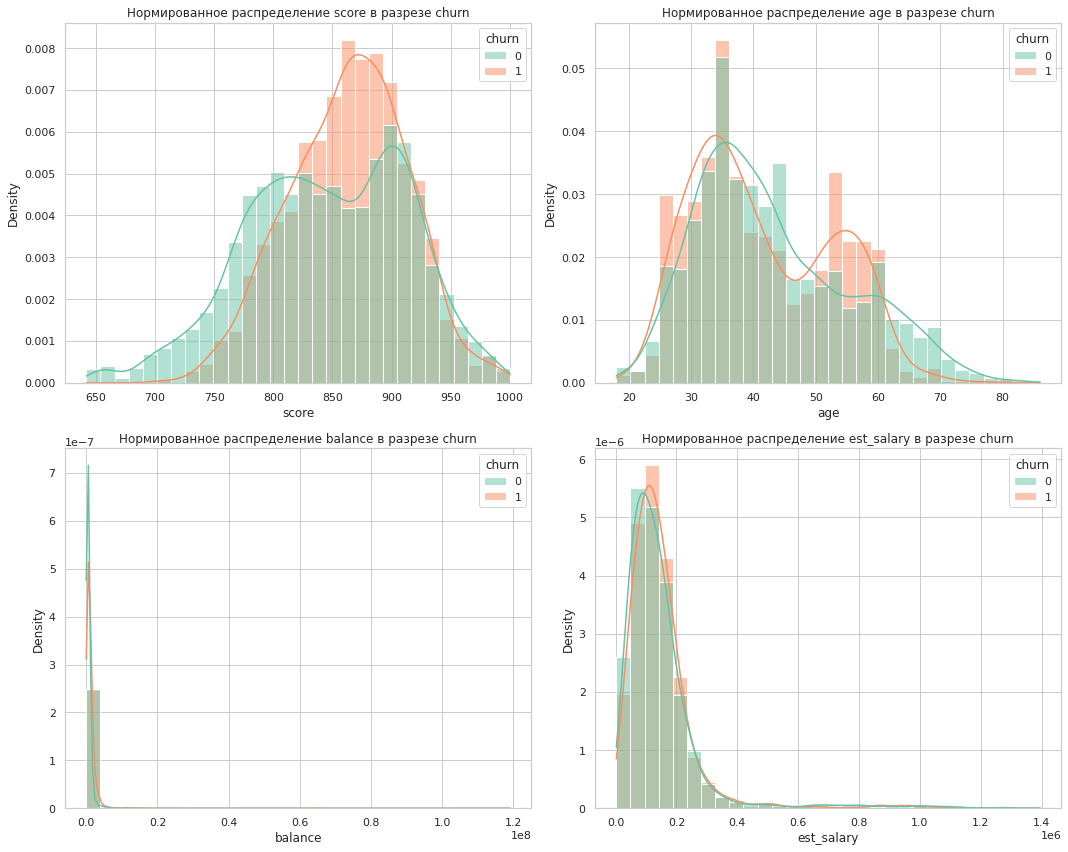

In [18]:
# Числовые признаки для анализа (исключаем equity)
numeric_features = ['score', 'age', 'balance', 'est_salary']

# Визуализация нормированных гистограмм
plt.figure(figsize=(15, 12))

for i, feature in enumerate(numeric_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data=data, x=feature, hue="churn", bins=30, stat="density", kde=True, common_norm=False, palette="Set2")
    plt.title(f'Нормированное распределение {feature} в разрезе churn')

plt.tight_layout()
plt.show()

Анализ распределения числовых признаков показал, что ушедшие клиенты имеют более высокий кредитный скоринг, что может указывать на то, что клиенты с хорошей кредитной историей более склонны к смене банка. Среди ушедших также выше доля клиентов в возрастной категории 30-50 лет, в то время как в группе оставшихся больше молодых и пожилых клиентов. Наличие собственности (`equity`) является фактором риска - чем больше объектов собственности у клиента, тем выше вероятность его ухода, особенно начиная с уровня `equity = 5`. В то же время баланс на счету не демонстрирует значительных различий между группами, а распределение доходов (`est_salary`) практически совпадает, что говорит о слабом влиянии баланса и дохода на отток. Таким образом, ключевыми числовыми факторами, связанными с оттоком, являются высокий кредитный скоринг, возраст 30-50 лет и наличие собственности, в то время как финансовые показатели, такие как баланс и доход, не оказывают значимого влияния.

Теперь изучим, как категориальные признаки (`is_male`, `city`, `products`, `credit_card`, `last_activity`) связаны с оттоком.

Средний уровень оттока по банку составляет 18.20%


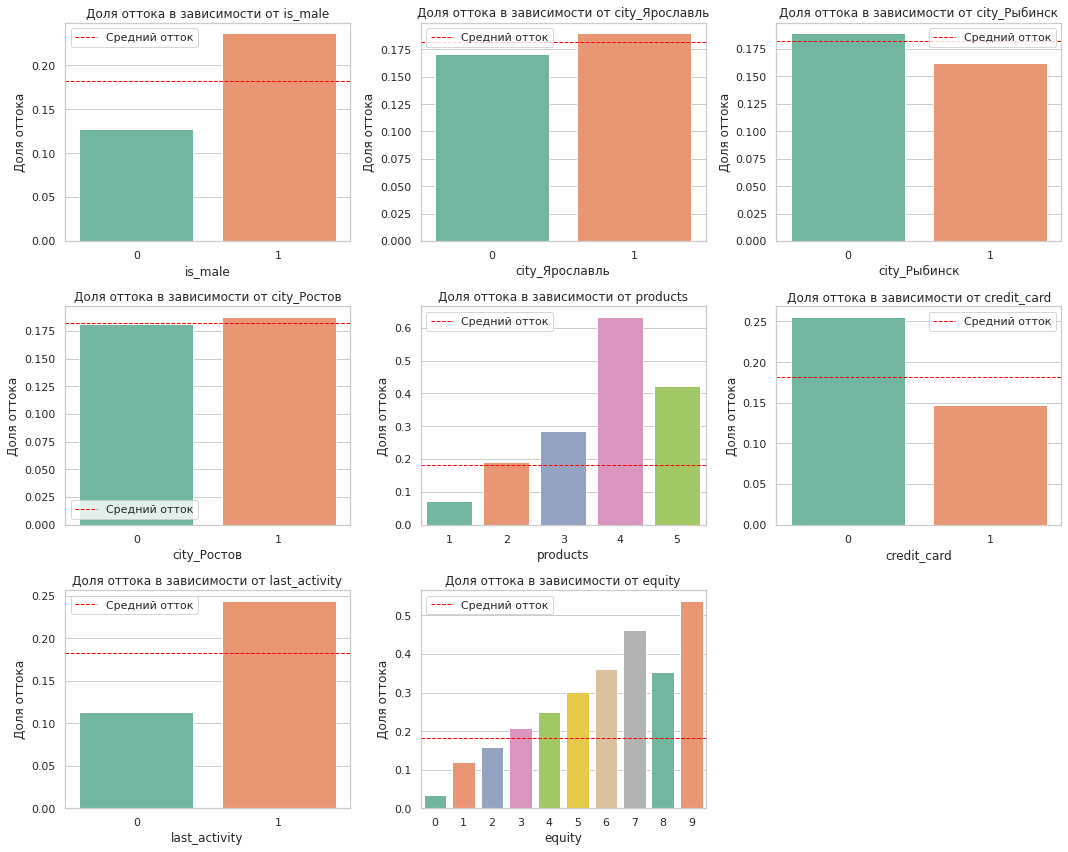

In [19]:
# Категориальные признаки для анализа (добавлен equity)
categorical_features = ['is_male', 'city_Ярославль', 'city_Рыбинск', 'city_Ростов', 
                        'products', 'credit_card', 'last_activity', 'equity']

# Средний уровень оттока по банку
avg_churn = data['churn'].mean()
print(f"Средний уровень оттока по банку составляет {avg_churn * 100:.2f}%")

# Визуализация долей оттока по категориям
plt.figure(figsize=(15, 12))

for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i)
    
    # Считаем доли оттока в каждой категории
    churn_rates = data.groupby(feature)['churn'].mean().reset_index()
    
    # Строим barplot с долями оттока
    sns.barplot(x=feature, y='churn', data=churn_rates, palette="Set2")
    
    # Добавляем средний уровень оттока по банку
    plt.axhline(avg_churn, color='red', linestyle='dashed', linewidth=1, label='Средний отток')
    
    plt.title(f'Доля оттока в зависимости от {feature}')
    plt.ylabel("Доля оттока")
    plt.xlabel(feature)
    plt.legend()

plt.tight_layout()
plt.show()

In [20]:
# Группируем данные по категориальным признакам и считаем процент оттока
churn_rates = data.groupby(categorical_features)['churn'].mean().reset_index()

# Сортируем по убыванию churn
churn_rates_sorted = churn_rates.sort_values(by='churn', ascending=False)

# Выводим топ-10 категорий с самым высоким оттоком
print("Топ-10 категорий с наибольшим оттоком:")
churn_rates_sorted.head(10)

Топ-10 категорий с наибольшим оттоком:


,is_male,city_Ярославль,city_Рыбинск,city_Ростов,products,credit_card,last_activity,equity,churn
481,1,0,1,0,4,1,0,5,1.0
509,1,1,0,0,1,1,1,7,1.0
484,1,0,1,0,4,1,1,3,1.0
182,0,0,1,0,4,1,1,6,1.0
179,0,0,1,0,4,1,1,3,1.0
178,0,0,1,0,4,1,1,2,1.0
177,0,0,1,0,4,1,1,0,1.0
176,0,0,1,0,4,1,0,0,1.0
487,1,0,1,0,4,1,1,7,1.0
172,0,0,1,0,4,0,1,0,1.0


In [21]:
# Выводим топ-10 категорий с наименьшим оттоком
print("\nТоп-10 категорий с наименьшим оттоком:")
churn_rates_sorted.tail(10)


Топ-10 категорий с наименьшим оттоком:


,is_male,city_Ярославль,city_Рыбинск,city_Ростов,products,credit_card,last_activity,equity,churn
453,1,0,1,0,3,0,0,7,0.0
454,1,0,1,0,3,0,1,3,0.0
455,1,0,1,0,3,0,1,4,0.0
457,1,0,1,0,3,1,0,0,0.0
214,0,1,0,0,2,0,0,8,0.0
213,0,1,0,0,2,0,0,7,0.0
212,0,1,0,0,2,0,0,6,0.0
463,1,0,1,0,3,1,0,6,0.0
464,1,0,1,0,3,1,0,9,0.0
303,1,0,0,1,1,0,0,3,0.0


Анализ категориальных признаков показал, что уровень оттока в банке составляет 18.2%, однако в ряде категорий он значительно превышает этот порог. Самый высокий уровень оттока наблюдается среди клиентов, использующих 4 или 5 банковских продуктов, что может указывать на неудовлетворенность тарифами или условиями обслуживания. Кроме того, наибольший отток демонстрируют клиенты из Ярославля и Рыбинска, в то время как в Ростове отток находится на уровне среднего по банку. Пол также является значимым фактором - мужчины уходят заметно чаще женщин. Среди клиентов, неактивных (`last_activity = 0`), уровень оттока также выше, что может свидетельствовать о слабой вовлеченности или отсутствии персонализированных предложений для таких пользователей. Наличие кредитной карты, напротив, связано с более низким уровнем оттока, что может указывать на более долгосрочное сотрудничество этих клиентов с банком. В то же время, наименьший отток наблюдается среди активных клиентов, использующих 1-2 банковских продукта, что говорит о высокой лояльности данной группы. Таким образом, ключевыми факторами, повышающими риск оттока, являются большое количество продуктов, неактивность, географическое расположение и пол клиента, тогда как наличие кредитной карты, наоборот, связано с более стабильным поведением клиентов.

### Корреляционный анализ

Теперь проведем корреляционный анализ, чтобы выявить, какие признаки наиболее связаны с оттоком (`churn`).

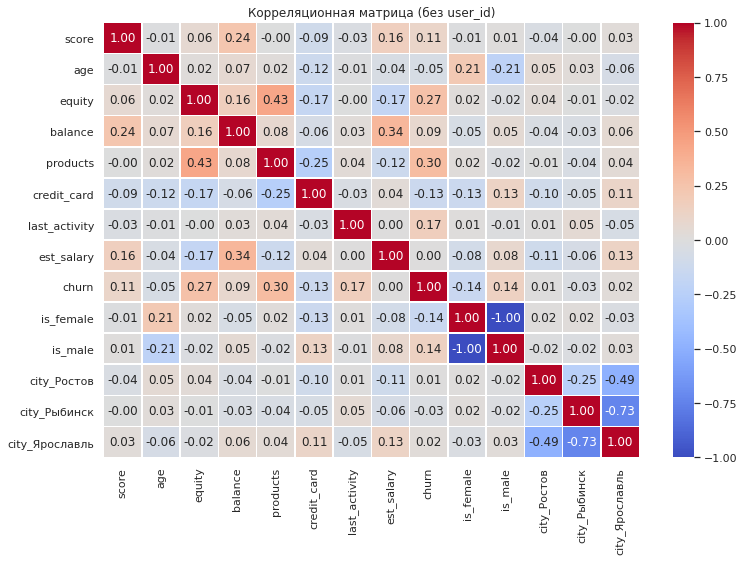

Корреляция признаков с churn:


churn             1.000000
products          0.301297
equity            0.270559
last_activity     0.168767
is_male           0.141036
score             0.105962
balance           0.085577
city_Ярославль    0.023905
city_Ростов       0.006024
est_salary        0.001273
city_Рыбинск     -0.031244
age              -0.049551
credit_card      -0.130790
is_female        -0.141036
Name: churn, dtype: float64

In [22]:
# Исключаем user_id перед расчетом корреляции
corr_matrix = data.drop(columns=['user_id']).corr()

# Строим тепловую карту корреляций
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, center=0)
plt.title("Корреляционная матрица (без user_id)")
plt.show()

# Выведем признаки, наиболее коррелирующие с churn
churn_corr = corr_matrix["churn"].sort_values(ascending=False)
print("Корреляция признаков с churn:")
churn_corr

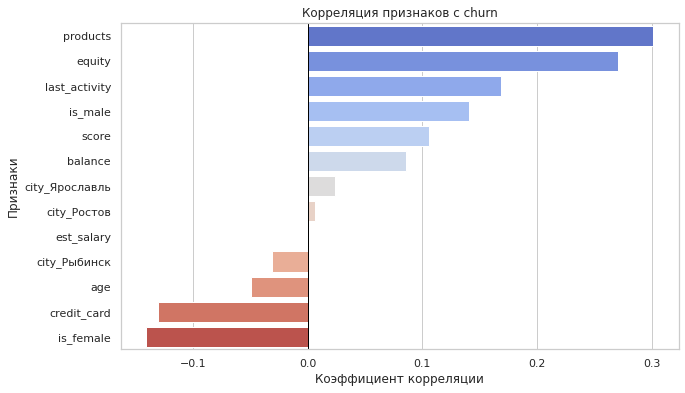

In [23]:
# Исключаем user_id перед расчетом корреляции
corr_matrix = data.drop(columns=['user_id']).corr()

# Рассчитываем корреляцию с churn
churn_corr = corr_matrix["churn"].drop("churn").sort_values(ascending=False)

# Визуализация корреляции churn с другими признаками
plt.figure(figsize=(10, 6))
sns.barplot(x=churn_corr.values, y=churn_corr.index, palette="coolwarm")
plt.xlabel("Коэффициент корреляции")
plt.ylabel("Признаки")
plt.title("Корреляция признаков с churn")
plt.axvline(0, color='black', linewidth=1)  # Добавляем вертикальную линию на 0
plt.show()

Корреляционный анализ показал, что наибольшую связь с оттоком клиентов (`churn`) имеют следующие признаки: количество продуктов (`products`), количество баллов собственности (`equity`) и активность клиента (`last_activity`). Наиболее выраженная положительная корреляция у `products` (0.30), что подтверждает предыдущие выводы - клиенты, использующие большее количество банковских услуг, чаще уходят. Вторым по значимости фактором является `equity` (0.27), что может указывать на то, что владельцы большего количества собственности более склонны менять банк. `last_activity` (0.17) также показывает положительную корреляцию с оттоком, что говорит о том, что часть активных клиентов может уходить.

Более слабую, но все же заметную положительную корреляцию с `churn` имеют `is_male` (0.14), что указывает на более высокую вероятность оттока среди мужчин, и `score` (0.10), что подтверждает гипотезу о том, что клиенты с более высоким кредитным рейтингом могут быть менее лояльными. `balance` имеет небольшую положительную корреляцию (0.08), что означает, что баланс на счете не является ключевым фактором оттока.

Среди признаков с отрицательной корреляцией самым значимым является `credit_card` (-0.13), что говорит о том, что клиенты, имеющие кредитную карту, в среднем реже уходят. `age` (-0.05) и `city_Рыбинск` (-0.03) имеют очень слабую отрицательную корреляцию, что указывает на незначительное влияние этих факторов.

В целом, корреляции с `churn` не слишком высокие, что может указывать на сложный многомерный характер факторов, влияющих на отток клиентов. Наиболее значимыми факторами остаются количество продуктов, собственность и активность клиента, что подтверждает ранее сделанные выводы. 

Также заметим, что среди признаков нет сильной корреляции друг с другом, что свидетельствует об их независимости и отсутствии выраженной мультиколлинеарности. Это означает, что каждый признак несет уникальную информацию, а дублирующих переменных нет. Поэтому на этапе кластеризации можно оставить все признаки, так как их удаление не требуется, и они могут вносить вклад в разделение клиентов на группы.

### Портрет клиента

Для построения таблицы "портрета клиента" разделим данные на две группы (`churn = 1` и `churn = 0`) и вычислим соответствующие показатели:
- Среднее для непрерывных величин (`est_salary`, `age`, `balance`, `score`).
- Медиана для дискретных (`products`, `equity`).
- Мода для категориальных (`city`, `is_male`, `credit_card`, `last_activity`).
- Рассчитаем относительную разницу, чтобы понять, насколько сильно отличаются показатели между группами.

In [24]:
# Разделение данных по churn
churned = data[data['churn'] == 1]
not_churned = data[data['churn'] == 0]

# Вычисляем средние значения для непрерывных признаков
avg_salary_churn = churned['est_salary'].mean()
avg_salary_not_churn = not_churned['est_salary'].mean()
avg_age_churn = churned['age'].mean()
avg_age_not_churn = not_churned['age'].mean()
avg_balance_churn = churned['balance'].mean()
avg_balance_not_churn = not_churned['balance'].mean()
avg_score_churn = churned['score'].mean()
avg_score_not_churn = not_churned['score'].mean()

# Вычисляем медиану для дискретных признаков
median_products_churn = churned['products'].median()
median_products_not_churn = not_churned['products'].median()
median_equity_churn = churned['equity'].median()
median_equity_not_churn = not_churned['equity'].median()

# Определяем моду для категориальных признаков
mode_city_churn = churned[['city_Ярославль', 'city_Рыбинск', 'city_Ростов']].sum().idxmax().replace('city_', '')
mode_city_not_churn = not_churned[['city_Ярославль', 'city_Рыбинск', 'city_Ростов']].sum().idxmax().replace('city_', '')

# Определяем моду для пола по исходным значениям
mode_gender_churn = 'Мужской' if churned['is_male'].mode()[0] == 1 else 'Женский'
mode_gender_not_churn = 'Мужской' if not_churned['is_male'].mode()[0] == 1 else 'Женский'

mode_credit_card_churn = churned['credit_card'].mode()[0]
mode_credit_card_not_churn = not_churned['credit_card'].mode()[0]
mode_activity_churn = churned['last_activity'].mode()[0]
mode_activity_not_churn = not_churned['last_activity'].mode()[0]

# Рассчитываем относительную разницу (только для непрерывных признаков)
relative_salary = (avg_salary_churn - avg_salary_not_churn) / avg_salary_not_churn * 100
relative_age = (avg_age_churn - avg_age_not_churn) / avg_age_not_churn * 100
relative_balance = (avg_balance_churn - avg_balance_not_churn) / avg_balance_not_churn * 100
relative_score = (avg_score_churn - avg_score_not_churn) / avg_score_not_churn * 100

# Создаем итоговую таблицу
portrait_df = pd.DataFrame({
    'Метрика': [
        'Средняя зарплата', 'Средний возраст', 'Средний баланс', 'Средний кредитный скоринг',
        'Медианное количество продуктов', 'Медианное количество собственности',
        'Мода по городу', 'Мода по полу', 'Мода по наличию кредитной карты', 'Мода по активности'
    ],
    'Отток': [
        avg_salary_churn, avg_age_churn, avg_balance_churn, avg_score_churn,
        median_products_churn, median_equity_churn, mode_city_churn, mode_gender_churn,
        mode_credit_card_churn, mode_activity_churn
    ],
    'Не отток': [
        avg_salary_not_churn, avg_age_not_churn, avg_balance_not_churn, avg_score_not_churn,
        median_products_not_churn, median_equity_not_churn, mode_city_not_churn, mode_gender_not_churn,
        mode_credit_card_not_churn, mode_activity_not_churn
    ],
    'Относительная разница (%)': [
        relative_salary, relative_age, relative_balance, relative_score,
        '-', '-', '-', '-', '-', '-'
    ]
})

portrait_df

,Метрика,Отток,Не отток,Относительная разница (%)
0,Средняя зарплата,148243.010198,147783.200108,0.311138
1,Средний возраст,41.449451,43.011614,-3.631957
2,Средний баланс,1133993.27145,733982.585648,54.498662
3,Средний кредитный скоринг,863.401099,845.428362,2.125873
4,Медианное количество продуктов,2.0,2.0,-
5,Медианное количество собственности,4.0,3.0,-
6,Мода по городу,Ярославль,Ярославль,-
7,Мода по полу,Мужской,Женский,-
8,Мода по наличию кредитной карты,1,1,-
9,Мода по активности,1,0,-


Анализ характеристик клиентов показал, что средняя зарплата практически не отличается между ушедшими и оставшимися клиентами (разница всего 0.31%), что подтверждает слабое влияние дохода на отток. Однако ушедшие клиенты в среднем обладают значительно более высоким балансом (+54.5%), что может свидетельствовать о том, что банк теряет наиболее финансово активных пользователей. Средний кредитный скоринг также выше у клиентов, покинувших банк (+2.13%), что указывает на возможную склонность клиентов с хорошей кредитной историей менять банк в поисках лучших условий.

Различия в возрасте хоть и присутствуют, но не критичны (-3.63% в пользу более молодых клиентов), а количество используемых банковских продуктов в медианном значении не отличается (2), что подтверждает, что сам факт использования нескольких услуг не является решающим фактором оттока. Однако количество собственности (`equity`) заметно выше среди ушедших клиентов (медианное значение 4 против 3), что подтверждает корреляционный анализ и указывает на возможную связь между уровнем собственности и склонностью к уходу.

По географическому признаку город Ярославль доминирует среди обеих групп, что говорит о том, что сам по себе географический фактор не является решающим. В то же время мужчины уходят заметно чаще женщин, что согласуется с более высоким уровнем оттока среди мужчин, выявленным в корреляционном анализе. Активные клиенты чаще попадают в группу оттока, что указывает на необходимость работы с удержанием даже среди вовлеченных пользователей.

Таким образом, ключевые различия между ушедшими и оставшимися клиентами связаны с полом, уровнем собственности и размером баланса, в то время как возраст и зарплата оказывают менее значимое влияние.

Анализ распределения признаков показал, что клиенты с более высоким кредитным скорингом, увеличенным балансом и высоким уровнем собственности (`equity`) чаще уходят, что может свидетельствовать о том, что банк теряет наиболее финансово активных пользователей. В то же время возраст и уровень дохода не оказывают значимого влияния, поскольку различия между группами минимальны. Среди категориальных признаков наибольший уровень оттока наблюдается среди клиентов, использующих 4 и более банковских продуктов, тогда как пользователи 1-2 услуг остаются лояльными. Мужчины демонстрируют более высокий уровень оттока по сравнению с женщинами, а также среди активных клиентов риск ухода выше, что может указывать на возможное неудовлетворение сервисом или тарифами.

Корреляционный анализ подтвердил, что наибольшее влияние на `churn` оказывают количество продуктов (`products`), уровень собственности (`equity`) и активность (`last_activity`), тогда как возраст, наличие кредитной карты и баланс на счете играют менее значимую роль. Отсутствие сильной корреляции между признаками позволяет использовать их все на этапе кластеризации, не исключая никакие переменные заранее.

Портрет клиента, склонного к оттоку, включает средний возраст 41 год, более высокий уровень собственности (медианное значение – 4), использование 2 и более банковских продуктов и преобладание мужчин в данной группе. При этом различий в уровне дохода между ушедшими и оставшимися клиентами практически нет, а наиболее часто встречающийся город остается неизменным – Ярославль.

Таким образом, ключевые факторы риска для оттока клиентов – использование большого числа банковских продуктов, высокий уровень собственности, мужской пол и определенный возрастной диапазон (30-50 лет). Эти выводы станут основой для дальнейшей кластеризации клиентов и разработки стратегий их удержания.

## Проверка гипотез

Сформулируем и проверим несколько гипотез, чтобы внести ясность в исследование.

### Гипотеза о доходах клиентов

- H0: Средний доход (`est_salary`) не различается между ушедшими и оставшимися клиентами.
- H1: Средний доход (`est_salary`) у ушедших клиентов отличается от оставшихся.
- Уровень значимости (α): 0.05 (5%).

Для выбора метода проверки гипотезы необходимо понять, как распределен `est_salary` в обеих группах (`churn = 0` и `churn = 1`).

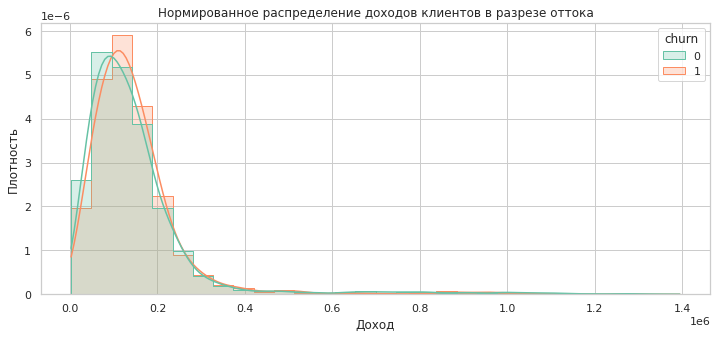

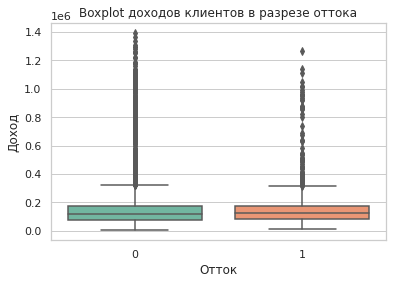

In [25]:
# Визуализация нормированного распределения доходов
plt.figure(figsize=(12, 5))

sns.histplot(data, x='est_salary', hue='churn', kde=True, bins=30, 
             element="step", palette="Set2", stat="density", common_norm=False)

plt.title("Нормированное распределение доходов клиентов в разрезе оттока")
plt.xlabel("Доход")
plt.ylabel("Плотность")
plt.show()

# Boxplot доходов по группам оттока
plt.figure(figsize=(6, 4))
sns.boxplot(x='churn', y='est_salary', data=data, palette="Set2")

plt.title("Boxplot доходов клиентов в разрезе оттока")
plt.xlabel("Отток")
plt.ylabel("Доход")
plt.show()

В соответствии с центральной предельной теоремой (ЦПТ), при достаточно большом объеме выборки t-тест можно применять даже к данным, распределение которых не является нормальным. Также, если размер выборок отличается более чем на 25%, параметр `equal_var` в t-тесте должен быть установлен в `False`, независимо от равенства дисперсий, для корректной работы теста.

In [26]:
# Вычисляем границы для удаления выбросов
Q1 = data['est_salary'].quantile(0.25)
Q3 = data['est_salary'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Удаляем выбросы
data_no_outliers = data[(data['est_salary'] >= lower_bound) & (data['est_salary'] <= upper_bound)]

# Разделяем данные на две группы
salary_churn = data_no_outliers[data_no_outliers['churn'] == 1]['est_salary']
salary_not_churn = data_no_outliers[data_no_outliers['churn'] == 0]['est_salary']

# Проверка разницы в размере выборок
size_ratio = max(len(salary_churn), len(salary_not_churn)) / min(len(salary_churn), len(salary_not_churn))
equal_var = size_ratio <= 1.25  # Если разница более 25%, ставим equal_var=False

# Проведение t-теста
test_stat, p_value = stats.ttest_ind(salary_churn, salary_not_churn, equal_var=equal_var)

# Вывод результатов
print(f"Статистика теста: {test_stat:.4f}")
print(f"P-значение: {p_value:.4f}")
print(f"Разница в размере выборок: {size_ratio:.2f}x")
print(f"equal_var установлен в: {equal_var}")

# Интерпретация результата
alpha = 0.05
if p_value < alpha:
    print("Отвергаем H0: средний доход ушедших клиентов значимо отличается от оставшихся.")
else:
    print("Не отвергаем H0: средний доход ушедших клиентов не отличается от оставшихся.")

Статистика теста: 3.8402
P-значение: 0.0001
Разница в размере выборок: 4.47x
equal_var установлен в: False
Отвергаем H0: средний доход ушедших клиентов значимо отличается от оставшихся.


Проверка гипотезы с помощью t-теста для независимых выборок показала, что p-value = 0.0001, что значительно меньше уровня значимости α = 0.05. Это означает, что нулевая гипотеза отвергается, и мы можем утверждать, что средний доход ушедших клиентов значимо отличается от дохода оставшихся клиентов. Поскольку размер выборок отличается более чем в 4 раза, тест был проведен с параметром `equal_var=False`, что обеспечивает корректность результата.

Важно отметить, что использование непараметрического теста было обосновано, поскольку распределения доходов оказались не нормальными, а дисперсии различались. Хотя на этапе EDA средние доходы казались схожими, статистический тест подтвердил, что разница действительно существенна с точки зрения статистики. Однако, даже при наличии значимого различия, с практической точки зрения эффект может быть небольшим, и на реальный процесс оттока доход влияет слабее, чем другие факторы.

### Гипотеза о связи количества продуктов и оттока

- H0: Среднее количество продуктов (`products`) у ушедших и оставшихся клиентов одинаково.
- H1: Среднее количество продуктов (`products`) у ушедших и оставшихся клиентов различается.
- Уровень значимости (α): 0.05 (5%).

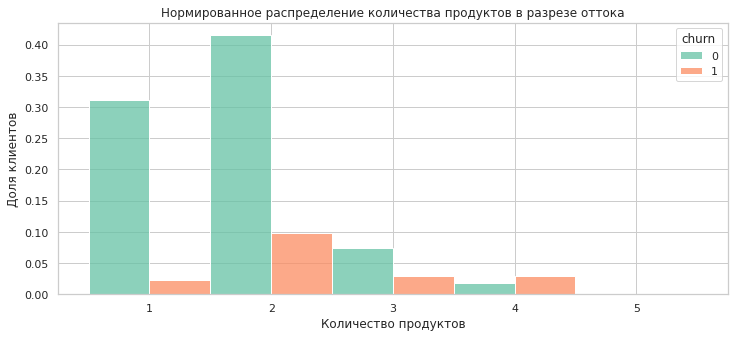

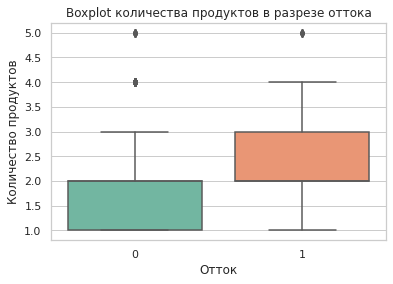

In [27]:
# Визуализация нормированного распределения количества продуктов
plt.figure(figsize=(12, 5))

sns.histplot(data, x='products', hue='churn', bins=6, discrete=True, element="bars", 
             palette="Set2", multiple="dodge", stat="probability")

plt.title("Нормированное распределение количества продуктов в разрезе оттока")
plt.xlabel("Количество продуктов")
plt.ylabel("Доля клиентов")
plt.show()

# Boxplot количества продуктов в разрезе оттока
plt.figure(figsize=(6, 4))
sns.boxplot(x='churn', y='products', data=data, palette="Set2")

plt.title("Boxplot количества продуктов в разрезе оттока")
plt.xlabel("Отток")
plt.ylabel("Количество продуктов")
plt.show()


Для проверки данной гипотезы лучше использовать непараметрический тест Манна-Уитни, так как он не требует нормального распределения и лучше подходит для сравнения двух групп с порядковыми или дискретными значениями.

In [28]:
# Разделяем выборки
products_churn = data[data['churn'] == 1]['products']
products_not_churn = data[data['churn'] == 0]['products']

# Тест Манна-Уитни
stat, p_value = mannwhitneyu(products_churn, products_not_churn, alternative='two-sided')

# Вывод результатов
print(f"Статистика Манна-Уитни: {stat:.4f}")
print(f"P-значение: {p_value:.7f}")

# Интерпретация результата
alpha = 0.05
if p_value < alpha:
    print("Отвергаем H0: количество продуктов у ушедших клиентов значимо отличается от оставшихся.")
else:
    print("Не отвергаем H0: количество продуктов у ушедших клиентов не отличается от оставшихся.")

Статистика Манна-Уитни: 10191562.5000
P-значение: 0.0000000
Отвергаем H0: количество продуктов у ушедших клиентов значимо отличается от оставшихся.


Тест Манна-Уитни показал p-value = 0.0000000, что значительно меньше уровня значимости α = 0.05. Это означает, что нулевая гипотеза отвергается, и количество продуктов у ушедших клиентов значимо отличается от оставшихся.

Ранее в EDA мы уже наблюдали, что клиенты с 4 и более продуктами гораздо чаще уходят, а те, кто использует 1-2 продукта, остаются лояльными. Теперь статистический тест подтвердил, что это различие статистически значимо.

### Гипотеза о связи количества собственности и оттока

- H0: Медианное количество собственности (`equity`) у ушедших и оставшихся клиентов одинаково.
- H1: Медианное количество собственности (`equity`) у ушедших и оставшихся клиентов различается.
- Уровень значимости (α): 0.05 (5%).

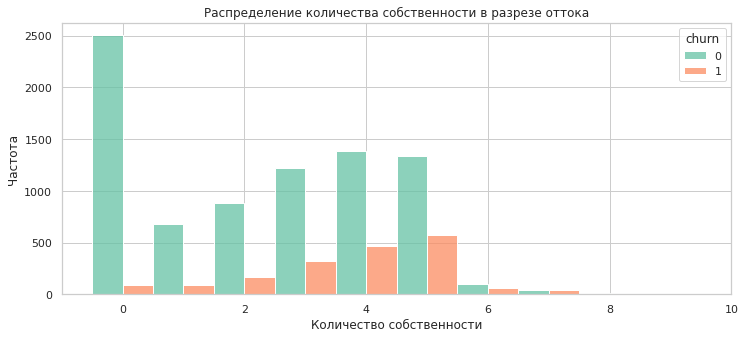

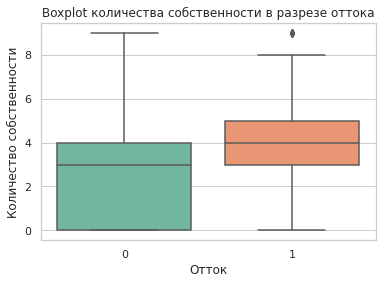

In [29]:
# Визуализация распределения количества собственности для ушедших и оставшихся клиентов
plt.figure(figsize=(12, 5))

# Гистограммы
sns.histplot(data, x='equity', hue='churn', bins=10, discrete=True, element="bars", palette="Set2", multiple="dodge")
plt.title("Распределение количества собственности в разрезе оттока")
plt.xlabel("Количество собственности")
plt.ylabel("Частота")
plt.show()

# Boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(x='churn', y='equity', data=data, palette="Set2")
plt.title("Boxplot количества собственности в разрезе оттока")
plt.xlabel("Отток")
plt.ylabel("Количество собственности")
plt.show()

Так как `equity` - дискретный показатель, как и `products`, снова используем тест Манна-Уитни.

In [30]:
# Разделяем выборки
equity_churn = data[data['churn'] == 1]['equity']
equity_not_churn = data[data['churn'] == 0]['equity']

# Тест Манна-Уитни
stat, p_value = mannwhitneyu(equity_churn, equity_not_churn, alternative='two-sided')

# Вывод результатов
print(f"Статистика Манна-Уитни: {stat:.4f}")
print(f"P-значение: {p_value:.4f}")

# Интерпретация результата
alpha = 0.05
if p_value < alpha:
    print("Отвергаем H0: количество собственности у ушедших клиентов значимо отличается от оставшихся.")
else:
    print("Не отвергаем H0: количество собственности у ушедших клиентов не отличается от оставшихся.")

Статистика Манна-Уитни: 10376158.5000
P-значение: 0.0000
Отвергаем H0: количество собственности у ушедших клиентов значимо отличается от оставшихся.


Тест Манна-Уитни показал p-value = 0.0000, что значительно меньше уровня значимости α = 0.05. Это означает, что нулевая гипотеза отвергается, и количество собственности у ушедших клиентов значимо отличается от оставшихся.

Ранее в EDA мы уже отмечали, что у клиентов, склонных к оттоку, медианное значение equity выше (4 против 3 у оставшихся), и статистический тест подтвердил это различие. Это может свидетельствовать о том, что клиенты с большей собственностью могут быть менее зависимы от банка и чаще менять финансовые учреждения.

### Гипотеза о связи возраста и оттока

- H0: Средний возраст ушедших и оставшихся клиентов не различается.
- H1: Средний возраст ушедших и оставшихся клиентов различается.
- Уровень значимости (α): 0.05 (5%).

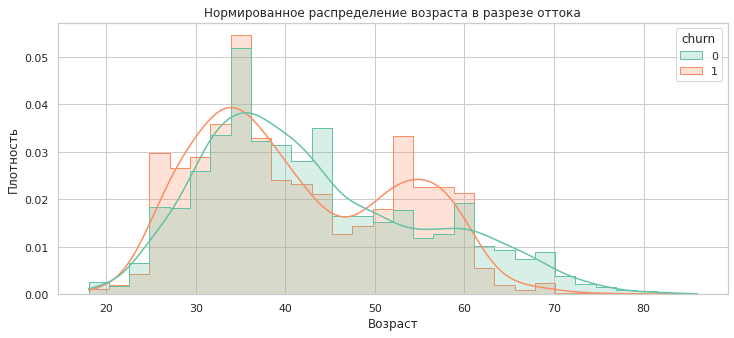

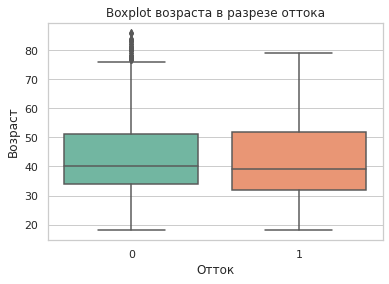

In [31]:
# Визуализация нормированного распределения возраста
plt.figure(figsize=(12, 5))

sns.histplot(data, x='age', hue='churn', bins=30, element="step", palette="Set2", kde=True,
             stat="density", common_norm=False)

plt.title("Нормированное распределение возраста в разрезе оттока")
plt.xlabel("Возраст")
plt.ylabel("Плотность")
plt.show()

# Boxplot возраста в разрезе оттока
plt.figure(figsize=(6, 4))
sns.boxplot(x='churn', y='age', data=data, palette="Set2")

plt.title("Boxplot возраста в разрезе оттока")
plt.xlabel("Отток")
plt.ylabel("Возраст")
plt.show()

Проведем тест аналогично первой гипотезе.

In [32]:
# Разделяем выборки
age_churn = data[data['churn'] == 1]['age']
age_not_churn = data[data['churn'] == 0]['age']

# Проверяем разницу в размере выборок
ratio = len(age_not_churn) / len(age_churn)
equal_var = ratio <= 1.25  # Если разница больше чем в 1.25 раза, устанавливаем equal_var=False

print(f"Разница в размере выборок: {ratio:.2f}x")
print(f"equal_var установлен в: {equal_var}")

# Проведение t-теста
test_stat, p_value = stats.ttest_ind(age_churn, age_not_churn, equal_var=equal_var)

# Вывод результатов
print(f"Статистика теста: {test_stat:.4f}")
print(f"P-значение: {p_value:.4f}")

# Интерпретация результата
alpha = 0.05
if p_value < alpha:
    print("Отвергаем H0: средний возраст ушедших клиентов значимо отличается от оставшихся.")
else:
    print("Не отвергаем H0: средний возраст ушедших клиентов не отличается от оставшихся.")

Разница в размере выборок: 4.49x
equal_var установлен в: False
Статистика теста: -5.2882
P-значение: 0.0000
Отвергаем H0: средний возраст ушедших клиентов значимо отличается от оставшихся.


T-тест для двух независимых выборок показал p-value = 0.0000, что значительно меньше уровня значимости α = 0.05. Это означает, что нулевая гипотеза отвергается, и мы можем утверждать, что средний возраст ушедших клиентов значимо отличается от возраста оставшихся клиентов.

Ранее в EDA было выявлено, что средний возраст клиентов в группе churn = 1 ниже, чем у оставшихся клиентов. Теперь статистический тест подтвердил, что это различие не является случайным. Это может свидетельствовать о том, что молодые клиенты менее лояльны к банку и чаще меняют его на другие финансовые организации, возможно, в поисках более выгодных условий или удобных цифровых сервисов.

### Гипотеза о связи пола и оттока

- H0: Пол клиента не влияет на вероятность оттока (процент ушедших мужчин и женщин одинаков).
- H1: Мужчины уходят чаще, чем женщины.
- Уровень значимости (α): 0.05 (5%).

Прежде чем выполнять тест, построим кросс-таблицу (`is_male` × `churn`), чтобы увидеть распределение долей.

In [33]:
# Создаем таблицу сопряженности
gender_churn_table = pd.crosstab(data['is_male'], data['churn'])

# Вывод таблицы
print("Таблица частот gender × churn:")
display(gender_churn_table)

# Рассчитываем доли ушедших клиентов среди мужчин и женщин
gender_churn_rates = gender_churn_table.div(gender_churn_table.sum(axis=1), axis=0)
print("\nДоли оттока среди мужчин и женщин:")
display(gender_churn_rates)

Таблица частот gender × churn:


churn,0,1
is_male,,
0,4358,637
1,3822,1183



Доли оттока среди мужчин и женщин:


churn,0,1
is_male,,
0,0.872472,0.127528
1,0.763636,0.236364


Так как обе переменные (`is_male` и `churn`) категориальные, применяем хи-квадрат тест независимости.

In [34]:
# Хи-квадрат тест
chi2_stat, p_value, dof, expected = chi2_contingency(gender_churn_table)

# Вывод результатов
print(f"Хи-квадрат статистика: {chi2_stat:.4f}")
print(f"P-значение: {p_value:.4f}")

# Интерпретация результата
alpha = 0.05
if p_value < alpha:
    print("Отвергаем H0: пол влияет на вероятность оттока, мужчины и женщины уходят с разной частотой.")
else:
    print("Не отвергаем H0: пол не влияет на вероятность оттока, доли ушедших клиентов одинаковы.")

Хи-квадрат статистика: 198.1816
P-значение: 0.0000
Отвергаем H0: пол влияет на вероятность оттока, мужчины и женщины уходят с разной частотой.


Хи-квадрат тест показал p-value = 0.0000, что значительно меньше уровня значимости α = 0.05. Это означает, что нулевая гипотеза отвергается, и пол значимо влияет на вероятность оттока.

Как видно из таблицы долей, мужчины уходят гораздо чаще, чем женщины (23.6% против 12.7%). Это подтверждает предыдущие наблюдения из EDA: среди ушедших клиентов действительно преобладают мужчины. Возможные причины такого поведения могут быть связаны с их финансовыми привычками, уровнем доверия к банку или активным поиском более выгодных условий в других организациях.

### Гипотеза о связи активности и оттока

- H0: Активность клиента (`last_activity`) не влияет на вероятность оттока (процент ушедших среди активных и неактивных одинаков).
- H1: Неактивные клиенты (`last_activity = 0`) уходят чаще, чем активные (`last_activity = 1`).
- Уровень значимости (α): 0.05 (5%).

Перед тестом посмотрим, как распределены активные и неактивные клиенты среди ушедших и оставшихся.

In [35]:
# Создаем таблицу сопряженности
activity_churn_table = pd.crosstab(data['last_activity'], data['churn'])

# Вывод таблицы
print("Таблица частот last_activity × churn:")
display(activity_churn_table)

# Рассчитываем доли ушедших клиентов среди активных и неактивных
activity_churn_rates = activity_churn_table.div(activity_churn_table.sum(axis=1), axis=0)
print("\nДоли оттока среди активных и неактивных клиентов:")
display(activity_churn_rates)

Таблица частот last_activity × churn:


churn,0,1
last_activity,,
0,4223,542
1,3957,1278



Доли оттока среди активных и неактивных клиентов:


churn,0,1
last_activity,,
0,0.886254,0.113746
1,0.755874,0.244126


Так как `last_activity` и `churn` - это категориальные переменные, снова используем хи-квадрат тест независимости.

In [36]:
# Хи-квадрат тест
chi2_stat, p_value, dof, expected = chi2_contingency(activity_churn_table)

# Вывод результатов
print(f"\nХи-квадрат статистика: {chi2_stat:.4f}")
print(f"P-значение: {p_value:.4f}")

# Интерпретация результата
alpha = 0.05
if p_value < alpha:
    print("Отвергаем H0: активность влияет на вероятность оттока, активные и неактивные клиенты уходят с разной частотой.")
else:
    print("Не отвергаем H0: активность не влияет на вероятность оттока, доли ушедших клиентов одинаковы.")


Хи-квадрат статистика: 283.9491
P-значение: 0.0000
Отвергаем H0: активность влияет на вероятность оттока, активные и неактивные клиенты уходят с разной частотой.


Хи-квадрат тест показал p-value = 0.0000, что значительно меньше уровня значимости α = 0.05. Это означает, что нулевая гипотеза отвергается, и активность значимо влияет на вероятность оттока.

Это подтверждает наблюдения из EDA: неактивные клиенты (`last_activity = 0`) чаще уходят, чем активные (`last_activity = 1`). Возможное объяснение - клиенты, которые долгое время не пользовались услугами банка, могут потерять к нему интерес или найти более выгодные альтернативы.

Статистический анализ подтвердил значимые различия между ушедшими и оставшимися клиентами по нескольким ключевым параметрам:
- Доход (`est_salary`) – p-value = 0.0001, отвергаем H0. Средний доход ушедших клиентов значимо отличается от оставшихся, хотя разница незначительна с практической точки зрения.
- Количество продуктов (`products`) – p-value = 0.0000, отвергаем H0. У ушедших клиентов значимо больше продуктов, чем у оставшихся. Это подтверждает, что пользователи с 4 и более продуктами чаще уходят.
- Количество собственности (`equity`) – p-value = 0.0000, отвергаем H0. У ушедших клиентов значимо больше собственности, что может говорить о меньшей зависимости таких клиентов от банка.
- Возраст (`age`) – p-value = 0.0000, отвергаем H0. У ушедших клиентов средний возраст ниже, что подтверждает гипотезу о том, что молодые клиенты менее лояльны.
- Пол (`gender`) – p-value = 0.0000, отвергаем H0. Мужчины уходят значимо чаще, чем женщины (23.6% против 12.7%).
- Активность (`last_activity`) – p-value = 0.0000, отвергаем H0. Неактивные клиенты уходят значимо чаще, чем активные, что подтверждает гипотезу о том, что низкая вовлеченность повышает вероятность оттока.

## Промежуточный вывод

Промежуточный анализ данных показал, что на отток клиентов значимо влияют несколько ключевых факторов. Клиенты, использующие большее количество продуктов, обладающие высоким уровнем собственности, а также мужчины и клиенты младшего возраста демонстрируют более высокий уровень оттока. Кроме того, неактивные пользователи чаще прекращают сотрудничество с банком, что подтверждает важность вовлеченности клиентов. При этом уровень дохода, несмотря на статистическую значимость различий, не оказывает значимого влияния на вероятность ухода.

На основе проведенного анализа для сегментации клиентов будут использоваться следующие признаки: количество продуктов (`products`), количество собственности (`equity`), возраст (`age`), активность (`last_activity`) и пол (`gender`). Эти факторы обеспечат разделение клиентов на группы с разной склонностью к оттоку, что позволит разработать эффективные стратегии удержания.

## Кластеризация клиентов

Прежде чем применять алгоритм кластеризации, выполним:
- Отбор признаков - используем только релевантные (`products`, `equity`, `age`, `last_activity`, `is_male`). Остальные признаки либо не показали значимой связи с `churn`, либо их влияние минимально. 
- Масштабирование данных - так как признаки имеют разные диапазоны значений, применяем MinMaxScaler. В данном случае MinMaxScaler оказался предпочтительнее, так как он сохраняет исходное распределение признаков в фиксированном диапазоне [0,1], что помогает K-Means корректно учитывать относительные различия между клиентами. В отличие от StandardScaler, который стандартизирует данные с учетом среднего и стандартного отклонения, MinMaxScaler не искажает порядок дискретных переменных, таких как `products` и `equity`, что особенно важно при кластеризации.

In [37]:
# Выбираем признаки для кластеризации
features = ['products', 'equity', 'age', 'last_activity', 'is_male']
X = data[features].copy()

# Масштабирование данных
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Выводим первые строки, чтобы проверить результат
X_scaled_df = pd.DataFrame(X_scaled, columns=features)
X_scaled_df.head()

,products,equity,age,last_activity,is_male
0,0.25,0.111111,0.102941,1.0,0.0
1,0.50,0.555556,0.279412,0.0,0.0
2,0.00,0.000000,0.176471,1.0,0.0
3,0.25,0.555556,0.485294,1.0,0.0
4,0.00,0.555556,0.235294,0.0,1.0


Используем K-Means с разным числом кластеров и строим график метода локтя, чтобы определить оптимальное число кластеров.

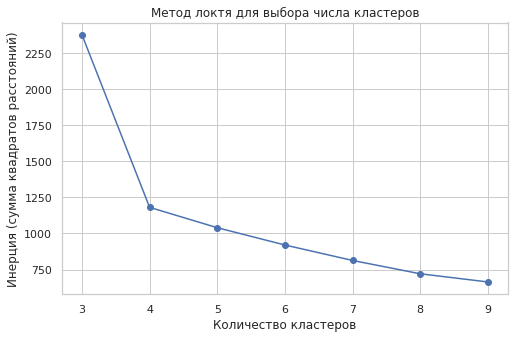

In [38]:
# Поиск оптимального числа кластеров методом "локтя"
inertia = []
k_range = range(3, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Визуализация метода локтя
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='-')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция (сумма квадратов расстояний)')
plt.title('Метод локтя для выбора числа кластеров')
plt.show()

Судя по графику, можем выбрать оптимальное число кластеров - 4. С большим числом кластеров график убывает медленнее, но для более реальной картины возьмем 7 кластеров.

In [39]:
# Оптимальное число кластеров
optimal_k = 7

# Применяем K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
data['cluster'] = kmeans.fit_predict(X_scaled)

# Вывод распределения клиентов по кластерам
print("Распределение клиентов по кластерам:")
data['cluster'].value_counts()

Распределение клиентов по кластерам:


3    2346
1    1506
5    1381
4    1270
2    1205
0    1149
6    1143
Name: cluster, dtype: int64

Оценим качество кластеризации с помощью силуэтного коэффициента.

In [40]:
# Получаем метки кластеров
cluster_labels = data['cluster']

# Вычисление силуэтного коэффициента
silhouette_avg = silhouette_score(X_scaled, cluster_labels)

# Вывод результата
print(f"Средний силуэтный коэффициент: {silhouette_avg:.4f}")

Средний силуэтный коэффициент: 0.4198


- Значение > 0.4 указывает на хорошее качество кластеризации.
- Кластеры достаточно разнесены, но есть небольшое наложение границ.
- Оптимальное число кластеров (7) в целом адекватно для сегментации.

In [41]:
# Группируем данные по кластерам и вычисляем средние значения
cluster_summary = data.groupby('cluster')[['products', 'equity', 'age', 'last_activity', 'is_male', 'churn']].mean()

# Вывод результатов
print("\nСредние характеристики по кластерам:")
cluster_summary


Средние характеристики по кластерам:


,products,equity,age,last_activity,is_male,churn
cluster,,,,,,
0,1.440383,0.791993,39.919060,0.0,1.0,0.080940
1,2.260956,4.132802,45.257636,1.0,0.0,0.284861
2,1.340249,0.679668,39.287137,1.0,1.0,0.099585
3,1.861893,2.672208,45.279199,0.0,0.0,0.055413
4,2.159055,4.221260,40.957480,0.0,1.0,0.251181
5,2.359160,4.233888,40.330920,1.0,1.0,0.471398
6,1.451444,0.740157,45.467192,1.0,0.0,0.068241


Кластеры с низким уровнем оттока (наименее рисковые сегменты):
1. Кластер 3 (отток 5.5% – самый низкий)
    - Возраст: 45 лет.
    - Среднее количество продуктов: 1.86 (умеренное).
    - Средний уровень собственности: 2.67 (умеренное).
    - Активность: полностью неактивные (last_activity = 0).
    - Пол: только женщины.
    - Вывод: Самая стабильная группа клиентов – несмотря на неактивность, они остаются в банке, возможно, из-за удобства, привычки или долгосрочного сотрудничества.


2. Кластер 0 (отток 8.1%)
    - Возраст: 39 лет (молодой сегмент).
    - Среднее количество продуктов: 1.44 (минимальное).
    - Средний уровень собственности: 0.79 (низкий).
    - Активность: полностью неактивные (last_activity = 0).
    - Пол: только мужчины.
    - Вывод: Клиенты, скорее всего, новички с небольшими активами, использующие только базовые услуги. Они стабильны, но их удержание может зависеть от будущего увеличения числа продуктов.
    
    
3. Кластер 6 (отток 6.8%)
    - Возраст: 45 лет.
    - Среднее количество продуктов: 1.45.
    - Средний уровень собственности: 0.74.
    - Активность: полностью активные (last_activity = 1).
    - Пол: только женщины.
    - Вывод: Лояльные клиенты с небольшим числом продуктов, активно пользующиеся банком, но не склонные к оттоку.



Кластеры со средним уровнем оттока (умеренный риск):    
1. Кластер 2 (отток 9.9%)
    - Возраст: 39 лет.
    - Среднее количество продуктов: 1.34.
    - Средний уровень собственности: 0.68.
    - Активность: полностью активные (last_activity = 1).
    - Пол: только мужчины.
    - Вывод: Молодые клиенты с низким числом продуктов, активно пользующиеся банком, но уровень оттока выше, чем в самом стабильном кластере.
    
    
2. Кластер 1 (отток 28.5%)
    - Возраст: 45 лет.
    - Среднее количество продуктов: 2.26 (выше среднего).
    - Средний уровень собственности: 4.13 (высокий).
    - Активность: полностью активные (last_activity = 1).
    - Пол: только женщины.
    - Вывод: Женщины с большим числом продуктов и активным использованием банка. Уровень оттока выше, возможно, из-за несоответствия ожиданиям или недостаточной персонализации.
   
   

Кластеры с высоким уровнем оттока (наиболее рисковые сегменты):
1. Кластер 4 (отток 25.1%)
    - Возраст: 41 лет.
    - Среднее количество продуктов: 2.16.
    - Средний уровень собственности: 4.22 (высокий).
    - Активность: полностью активные (last_activity = 1).
    - Пол: только мужчины.
    - Вывод: Мужчины с высоким количеством продуктов и активным использованием банка, но высокий уровень оттока может указывать на неудовлетворенность сервисом или поиски лучших условий.
    
    
2. Кластер 5 (отток 47.1% – самый высокий)
    - Возраст: 40 лет.
    - Среднее количество продуктов: 2.36 (максимальное среди всех кластеров).
    - Средний уровень собственности: 4.23 (максимальное среди всех кластеров).
    - Активность: полностью активные (last_activity = 1).
    - Пол: только мужчины.
    - Вывод: Самый критичный сегмент – клиенты с максимальным числом продуктов, высокой собственностью и активным использованием услуг. Они составляют основную группу риска, возможно, из-за слишком сложной структуры продуктов или высоких тарифов.

## Приоритизация сегментов

Приоритетность сегментов можно определить по двум ключевым критериям:
1. Уровень оттока - чем выше, тем важнее сегмент с точки зрения удержания.
2. Размер сегмента - если в сегменте мало клиентов, его влияние на общий отток незначительно.

In [42]:
# Определяем средний уровень оттока по банку
avg_churn_rate = data["churn"].mean() * 100
high_risk_threshold = avg_churn_rate * 1.5  # Критический уровень оттока
medium_risk_threshold = avg_churn_rate * 1.1  # Умеренно высокий уровень оттока

# Группируем данные по кластерам
cluster_summary = data.groupby("cluster").agg(
    churn_rate=("churn", "mean"),  # Средний уровень оттока в кластере
    num_clients=("churn", "count"),  # Количество клиентов в кластере
    avg_products=("products", "mean"),
    avg_equity=("equity", "mean"),
    avg_age=("age", "mean"),
    is_male_mode=("is_male", lambda x: x.mode()[0]),  # Мода по полу
    last_activity_mode=("last_activity", lambda x: x.mode()[0])  # Мода по активности
).reset_index()

# Преобразуем отток в проценты
cluster_summary["churn_rate"] = (cluster_summary["churn_rate"] * 100).round(1)

# Определяем приоритет кластера
def assign_priority(churn_rate):
    if churn_rate > high_risk_threshold:
        return "Высокий"
    elif churn_rate > medium_risk_threshold:
        return "Средний"
    else:
        return "Низкий"

cluster_summary["priority"] = cluster_summary["churn_rate"].apply(assign_priority)

# Добавляем описание кластеров
def describe_cluster(row):
    gender = "Мужчины" if row["is_male_mode"] == 1 else "Женщины"
    activity = "активные" if row["last_activity_mode"] == 1 else "неактивные"
    return f"{gender}, {activity}, {row['avg_products']:.1f} продуктов, {row['avg_equity']:.1f} собственности"

cluster_summary["description"] = cluster_summary.apply(describe_cluster, axis=1)

# Переименовываем столбцы
cluster_summary.rename(columns={
    "cluster": "Кластер",
    "churn_rate": "Отток (%)",
    "num_clients": "Количество клиентов",
    "priority": "Приоритет",
    "description": "Основные характеристики"
}, inplace=True)

# Сортируем по уровню оттока (по убыванию)
cluster_summary = cluster_summary.sort_values(by="Отток (%)", ascending=False)

cluster_summary

,Кластер,Отток (%),Количество клиентов,avg_products,avg_equity,avg_age,is_male_mode,last_activity_mode,Приоритет,Основные характеристики
5,5,47.1,1381,2.359160,4.233888,40.330920,1,1,Высокий,"Мужчины, активные, 2.4 продуктов, 4.2 собственности"
1,1,28.5,1506,2.260956,4.132802,45.257636,0,1,Высокий,"Женщины, активные, 2.3 продуктов, 4.1 собственности"
4,4,25.1,1270,2.159055,4.221260,40.957480,1,0,Средний,"Мужчины, неактивные, 2.2 продуктов, 4.2 собственности"
2,2,10.0,1205,1.340249,0.679668,39.287137,1,1,Низкий,"Мужчины, активные, 1.3 продуктов, 0.7 собственности"
0,0,8.1,1149,1.440383,0.791993,39.919060,1,0,Низкий,"Мужчины, неактивные, 1.4 продуктов, 0.8 собственности"
6,6,6.8,1143,1.451444,0.740157,45.467192,0,1,Низкий,"Женщины, активные, 1.5 продуктов, 0.7 собственности"
3,3,5.5,2346,1.861893,2.672208,45.279199,0,0,Низкий,"Женщины, неактивные, 1.9 продуктов, 2.7 собственности"


1. Кластер 5 - Приоритет №1
    - Самый высокий отток (47.1%) – почти половина клиентов уходит.
    - Мужчины, активные пользователи, в среднем 2.4 продукта и 4.2 собственности.
    - Причина риска: Клиенты активно пользуются услугами, но уходят, возможно, из-за неудовлетворенности сервисом, поиска лучших условий или неудобных тарифов.
    - Стратегия: Важно удержать этот сегмент, предложив персонализированные скидки, бонусы, улучшенные тарифы и вовлечение в программы лояльности.


2. Кластер 1 - Приоритет №2
    - Отток 28.5% – выше среднего, но ниже, чем в кластере 5.
    - Женщины, активные пользователи, в среднем 2.3 продукта и 4.1 собственности.
    - Причина риска: Возможно, клиенты не получают персонализированных предложений, не видят ценности в обслуживании или находят более привлекательные альтернативы.
    - Стратегия: Развитие персонализированных предложений, акцент на удобство обслуживания, эксклюзивные условия для женщин.


3. Кластер 4 - Приоритет №3
    - Отток 25.1% – ниже, чем в кластерах 5 и 1, но все же высокий.
    - Мужчины, неактивные пользователи, в среднем 2.2 продукта и 4.2 собственности.
    - Причина риска: Клиенты обладают значительными активами, но не проявляют активности. Возможно, их не вовлекают в использование новых услуг или у них нет мотивации оставаться в банке.
    - Стратегия: Программа повторного вовлечения, специальные акции и индивидуальные предложения для стимуляции активности.

## Формирование рекомендаций

Для сегментов с высоким риском оттока:

Кластер 5 (Мужчины, активные, 2.4 продукта, 4.2 собственности, отток 47.1%):
- Основные характеристики: Это активные пользователи с максимальным числом продуктов и высоким уровнем собственности. Клиенты вовлечены в банковские сервисы, но ищут лучшие условия.
- Рекомендации:
    - Программы премиального обслуживания: предложения с индивидуальными условиями, приоритетное обслуживание, персональные менеджеры.
    - Оптимизация тарифов: анализ конкурентов, снижение скрытых комиссий, улучшение условий на инвестиционные продукты.
    - Программа лояльности: начисление бонусов за активное использование услуг, скидки при длительном сотрудничестве.
    - Выявление причин оттока: анкетирование клиентов, анализ жалоб и отзывов, устранение ключевых проблем.

Кластер 1 (Женщины, активные, 2.3 продукта, 4.1 собственности, отток 28.5%)
- Основные характеристики: Женщины активно пользуются банковскими услугами, но могут не находить предложений, соответствующих их потребностям.
- Рекомендации:
    - Персонализированные предложения: разработка финансовых продуктов для семей, инвестиционные инструменты, адаптированные под потребности женщин.
    - Программы рекомендаций: бонусы за приглашение новых клиентов, совместные акции с партнерскими компаниями.
    - Улучшение клиентского сервиса: акцент на гибкость и удобство взаимодействия с банком, расширение онлайн-услуг.
    - Анализ конкурентов: выявление преимуществ других банков, внедрение востребованных решений.

Кластер 4 (Мужчины, неактивные, 2.2 продукта, 4.2 собственности, отток 25.1%)
- Основные характеристики: Мужчины с высокой собственностью и умеренным числом продуктов, но низкой активностью. Клиенты с потенциально большим капиталом, но не вовлечены в использование банковских услуг.
- Рекомендации:
    - Возвращение клиентов к активности: бонусы за использование сервисов, специальные акции для "спящих" клиентов.
    - Индивидуальные инвестиционные предложения: консультации по управлению капиталом, премиальные депозиты.
    - Оповещения о выгодных возможностях: email-рассылки, push-уведомления с персонализированными предложениями.
    - Программы лояльности: поощрение за продолжительное сотрудничество с банком.

Для стабильных сегментов:

Кластер 2 (Мужчины, активные, 1.3 продукта, 0.7 собственности, отток 10.0%)
- Основные характеристики: Активные пользователи с низким числом продуктов и минимальной собственностью. Потенциальные клиенты для расширения спектра используемых услуг.
- Рекомендации:
    - Мотивация к использованию дополнительных услуг: информирование о доступных продуктах, кэшбэк-программы.
    - Анализ потребностей клиентов: сбор обратной связи, персонализированные предложения.
    - Программы повышения вовлеченности: геймификация, бонусы за регистрацию в новых сервисах.

Кластер 0 (Мужчины, неактивные, 1.4 продукта, 0.8 собственности, отток 8.1%)
- Основные характеристики: Минимальное число продуктов, невысокая активность, но низкий уровень оттока. Клиенты, которые не уходят, но и не проявляют интереса к дополнительным услугам.
- Рекомендации:
    - Стимулирование активности: специальные акции, персонализированные предложения.
    - Развитие удобных сервисов: улучшение мобильного приложения, расширение онлайн-банкинга.
    - Ненавязчивая коммуникация: напоминания о возможностях банка, бонусные программы.

Кластер 6 (Женщины, активные, 1.5 продукта, 0.7 собственности, отток 6.8%)
- Основные характеристики: Женщины с небольшим числом продуктов, активные пользователи, минимальный отток.
- Рекомендации:
    - Поддержка высокого уровня удовлетворенности: гибкость условий, оперативное обслуживание.
    - Расширение программ лояльности: дополнительные привилегии за длительное сотрудничество.
    - Создание предложений под сегмент: финансовые программы, ориентированные на женщин.

Кластер 3 (Женщины, неактивные, 1.9 продукта, 2.7 собственности, отток 5.5%)
- Основные характеристики: Женщины с умеренным числом продуктов, но неактивные пользователи. Самый стабильный кластер.
- Рекомендации:
    - Поддержание текущего уровня сервиса: мониторинг удовлетворенности, работа с обратной связью.
    - Дополнительная мотивация к активности: ненавязчивые предложения, информирование о новых продуктах.

Основные усилия должны быть сосредоточены на кластерах 5, 1 и 4, так как в них наблюдается высокий уровень оттока. Для них требуются персонализированные предложения, программы лояльности и оптимизация тарифов. Остальные сегменты также важно поддерживать, но их риски ниже, и рекомендации сосредоточены на повышении вовлеченности и удовлетворенности клиентов.